# Filtering Well Data

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from arcgis.gis import GIS
from scipy.spatial import cKDTree

In [102]:
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

This notebook examines both the periodic well data and continuous well data for the central valley. The goal is to filter wells by quality, geography, and depth to form a dataset that can be reliably used to interpolate water level and water storage in the central valley.

## Loading relevant shapefiles

First, we must load some relevant shapefiles. We'll grab California, the Central Valley, the Corcorcan Clay, and the zone map for CVHM (to do: add CV2Sim)

In [12]:
CA_map = gpd.read_file('Shapefiles/CA_State_TIGER2016.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CA_map.crs)
CA_map.to_crs(epsg='4326', inplace=True)

PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]


In [13]:
CV_map = gpd.read_file('Shapefiles/Alluvial_Bnd.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CV_map.crs)
CV_map.to_crs(epsg='4326', inplace=True)

PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [14]:
CC_map = gpd.read_file('Shapefiles/corcoran_clay_depth_feet.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CC_map.crs)
CC_map.to_crs(epsg='4326', inplace=True)

PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


From the Central Valley Hydrologic Model, we can grab the relevant thickness layers for each zone and build a subsurface map to determine unconfined vs. semi-confined vs. confined as a high level.

In [114]:
zone_map = gpd.read_file('Shapefiles/ZONE.shp')
zone_map.to_crs(epsg='4326', inplace=True)
zone_map = zone_map.sort_values(['ROW', 'COLUMN_'], ascending=[True, True])
zone_map.head()

,OBJECTID,CELLNUM,ROW,COLUMN_,l1zoneqpc,l2zoneqpc,l3zoneqpc,l4zone,l5zone,l6zoneqpc,l7zoneqpc,l8zoneqpc,l9zoneqpc,l10zoneqpc,lay2_act,lay3_act,geometry
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-123.76721 39.97383, -123.78320 39.9..."
1,2,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-123.75121 39.98159, -123.76721 39.9..."
2,3,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-123.73521 39.98935, -123.75121 39.9..."
3,4,4,1,4,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-123.71921 39.99711, -123.73521 39.9..."
4,5,5,1,5,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-123.70320 40.00486, -123.71921 39.9..."


In [115]:
### not the most pythonic way of doing this...

layer1 = np.genfromtxt('Shapefiles/FIN_THK_L1C.txt', delimiter=',').flatten()
layer2 = np.genfromtxt('Shapefiles/FIN_THK_L2C.txt', delimiter=',').flatten()
layer3 = np.genfromtxt('Shapefiles/FIN_THK_L3.txt', delimiter=',').flatten()
layer4 = np.genfromtxt('Shapefiles/FIN_THK_L4.txt', delimiter=',').flatten()
layer5 = np.genfromtxt('Shapefiles/FIN_THK_L5.txt', delimiter=',').flatten()
layer6 = np.genfromtxt('Shapefiles/FIN_THK_L6.txt', delimiter=',').flatten()
layer7 = np.genfromtxt('Shapefiles/FIN_THK_L7.txt', delimiter=',').flatten()
layer8 = np.genfromtxt('Shapefiles/FIN_THK_L8.txt', delimiter=',').flatten()
layer9 = np.genfromtxt('Shapefiles/FIN_THK_L9.txt', delimiter=',').flatten()
layer10 = np.genfromtxt('Shapefiles/FIN_THK_L10.txt', delimiter=',').flatten()

In [116]:
zone_map['layer1_thk'] = layer1
zone_map['layer2_thk'] = layer2
zone_map['layer3_thk'] = layer3
zone_map['layer4_thk'] = layer4
zone_map['layer5_thk'] = layer5
zone_map['layer6_thk'] = layer6
zone_map['layer7_thk'] = layer7
zone_map['layer8_thk'] = layer8
zone_map['layer9_thk'] = layer9
zone_map['layer10_thk'] = layer10

The depth of interest will depend on what we are interested in. The CVHM defines the corcoran clay as starting at layer 4, so if we add the thicknesses of the first three layers, that should give us the depth of the bottom of layer 3. For now, I defined this as the unconfined bottom.

In [117]:
zone_map['unconfined_bot'] = zone_map['layer1_thk'] + zone_map['layer2_thk'] + zone_map['layer3_thk']

In [118]:
zone_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 43218 entries, 0 to 43217
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   OBJECTID        43218 non-null  int64   
 1   CELLNUM         43218 non-null  int64   
 2   ROW             43218 non-null  int64   
 3   COLUMN_         43218 non-null  int64   
 4   l1zoneqpc       43218 non-null  int64   
 5   l2zoneqpc       43218 non-null  int64   
 6   l3zoneqpc       43218 non-null  int64   
 7   l4zone          43218 non-null  int64   
 8   l5zone          43218 non-null  int64   
 9   l6zoneqpc       43218 non-null  int64   
 10  l7zoneqpc       43218 non-null  int64   
 11  l8zoneqpc       43218 non-null  int64   
 12  l9zoneqpc       43218 non-null  int64   
 13  l10zoneqpc      43218 non-null  int64   
 14  lay2_act        43218 non-null  int64   
 15  lay3_act        43218 non-null  int64   
 16  geometry        43218 non-null  geometry
 17  laye

Text(0.5, 1.0, 'Shapefiles for California, Central Valley, and Corcoran Clay')

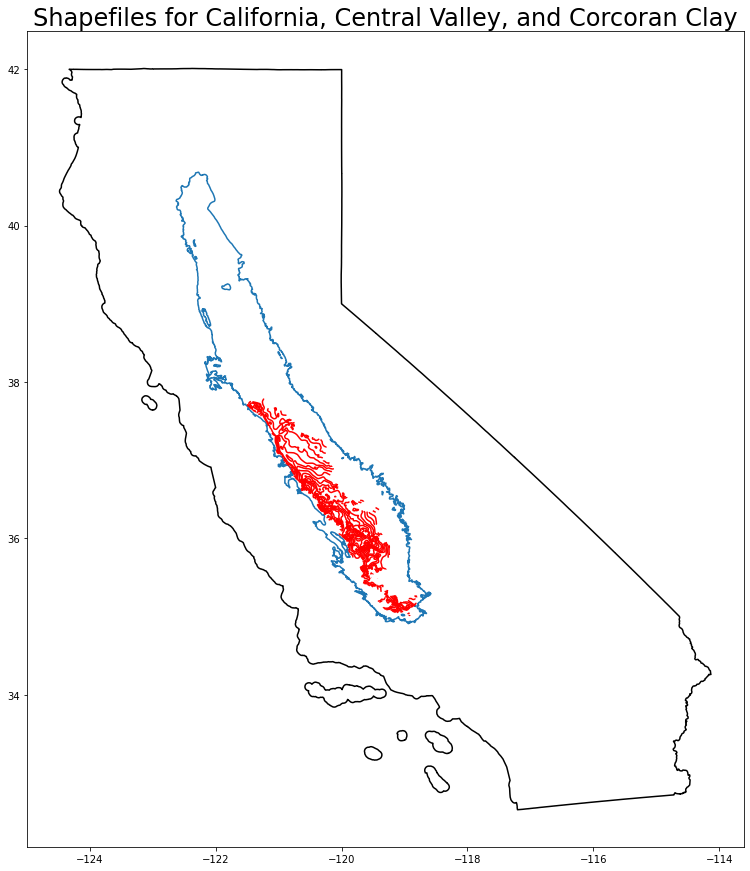

In [152]:
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k')
CV_map.boundary.plot(ax=ax)
#zone_map.boundary.plot(ax=ax, color='k')
CC_map.plot(ax=ax, color='r')
ax.set_title('Shapefiles for California, Central Valley, and Corcoran Clay', fontsize=24)

# Periodic Data

We can examine that periodic data first. We will read in the csv files and check the dataframes using Panda's info() function. The full meaning of each column type can be found by previewing the files on DWR's periodic groundwater levels website. https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements For each corresponding file, use the preview button and then expand the data dictionary table on the webpage.

## read in csv files

In [120]:
well_measurements = pd.read_csv('./well_data/measurements.csv')
well_stations = pd.read_csv('./well_data/stations.csv')
well_perforations = pd.read_csv('./well_data/perforations.csv')

In [121]:
well_measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532521 entries, 0 to 2532520
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   SITE_CODE           object 
 1   WLM_ID              int64  
 2   MSMT_DATE           object 
 3   WLM_RPE             float64
 4   WLM_GSE             float64
 5   GWE                 float64
 6   GSE_GWE             float64
 7   WLM_QA_DESC         object 
 8   WLM_DESC            object 
 9   WLM_ACC_DESC        object 
 10  WLM_ORG_NAME        object 
 11  COOP_ORG_NAME       object 
 12  MONITORING_PROGRAM  object 
 13  MSMT_CMT            object 
dtypes: float64(4), int64(1), object(9)
memory usage: 270.5+ MB


In [122]:
well_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45924 entries, 0 to 45923
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STN_ID              45924 non-null  int64  
 1   SITE_CODE           45924 non-null  object 
 2   SWN                 41453 non-null  object 
 3   WELL_NAME           17847 non-null  object 
 4   LATITUDE            45924 non-null  float64
 5   LONGITUDE           45924 non-null  float64
 6   GSE                 45914 non-null  float64
 7   GSE_METHOD          45924 non-null  object 
 8   GSE_ACC             45924 non-null  object 
 9   BASIN_CODE          42907 non-null  object 
 10  BASIN_NAME          42907 non-null  object 
 11  COUNTY_NAME         45924 non-null  object 
 12  WELL_DEPTH          13465 non-null  float64
 13  WELL_USE            44528 non-null  object 
 14  WELL_TYPE           45924 non-null  object 
 15  WCR_NO              6313 non-null   object 
 16  MONI

In [123]:
well_stations = well_stations.drop('MONITORING_PROGRAM', 1)
# dropping this column to avoid issues with a join function
# we still have monitoring program information from the well measurements object

/var/folders/6z/fy9gryg51yvcsygp2msy65400000gq/T/ipykernel_7517/783398191.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  well_stations = well_stations.drop('MONITORING_PROGRAM', 1)


In [124]:
well_stations.info()
print(well_stations["WELL_USE"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45924 entries, 0 to 45923
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STN_ID       45924 non-null  int64  
 1   SITE_CODE    45924 non-null  object 
 2   SWN          41453 non-null  object 
 3   WELL_NAME    17847 non-null  object 
 4   LATITUDE     45924 non-null  float64
 5   LONGITUDE    45924 non-null  float64
 6   GSE          45914 non-null  float64
 7   GSE_METHOD   45924 non-null  object 
 8   GSE_ACC      45924 non-null  object 
 9   BASIN_CODE   42907 non-null  object 
 10  BASIN_NAME   42907 non-null  object 
 11  COUNTY_NAME  45924 non-null  object 
 12  WELL_DEPTH   13465 non-null  float64
 13  WELL_USE     44528 non-null  object 
 14  WELL_TYPE    45924 non-null  object 
 15  WCR_NO       6313 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 5.6+ MB
['Residential' 'Unknown' 'Observation' 'Other' 'Irrigation'
 'Public Sup

In [125]:
well_perforations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13606 entries, 0 to 13605
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SITE_CODE    13606 non-null  object 
 1   TOP_PRF_INT  13606 non-null  float64
 2   BOT_PRF_INT  13606 non-null  float64
dtypes: float64(2), object(1)
memory usage: 319.0+ KB


As shown above, the data is in several files that we need to combine. We'll start by combining the station and perforation data. Per the DWR's readme, any given well can have up to 10 perforations, so we'll add 10 perforation "slots" to our data frame.

In [126]:
well_stations = well_stations.drop_duplicates(subset=['SITE_CODE'])

In [127]:
added_column_list = list(well_stations.columns)
print(added_column_list)
added_column_list.extend(['TOP_PRF_INT_0', 'BOT_PRF_INT_0',
                        'TOP_PRF_INT_1', 'BOT_PRF_INT_1',
                        'TOP_PRF_INT_2', 'BOT_PRF_INT_2',
                        'TOP_PRF_INT_3', 'BOT_PRF_INT_3',
                        'TOP_PRF_INT_4', 'BOT_PRF_INT_4',
                        'TOP_PRF_INT_5', 'BOT_PRF_INT_5',
                        'TOP_PRF_INT_6', 'BOT_PRF_INT_6',
                        'TOP_PRF_INT_7', 'BOT_PRF_INT_7',
                        'TOP_PRF_INT_8', 'BOT_PRF_INT_8',
                        'TOP_PRF_INT_9', 'BOT_PRF_INT_9'])
print(added_column_list)

['STN_ID', 'SITE_CODE', 'SWN', 'WELL_NAME', 'LATITUDE', 'LONGITUDE', 'GSE', 'GSE_METHOD', 'GSE_ACC', 'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME', 'WELL_DEPTH', 'WELL_USE', 'WELL_TYPE', 'WCR_NO']
['STN_ID', 'SITE_CODE', 'SWN', 'WELL_NAME', 'LATITUDE', 'LONGITUDE', 'GSE', 'GSE_METHOD', 'GSE_ACC', 'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME', 'WELL_DEPTH', 'WELL_USE', 'WELL_TYPE', 'WCR_NO', 'TOP_PRF_INT_0', 'BOT_PRF_INT_0', 'TOP_PRF_INT_1', 'BOT_PRF_INT_1', 'TOP_PRF_INT_2', 'BOT_PRF_INT_2', 'TOP_PRF_INT_3', 'BOT_PRF_INT_3', 'TOP_PRF_INT_4', 'BOT_PRF_INT_4', 'TOP_PRF_INT_5', 'BOT_PRF_INT_5', 'TOP_PRF_INT_6', 'BOT_PRF_INT_6', 'TOP_PRF_INT_7', 'BOT_PRF_INT_7', 'TOP_PRF_INT_8', 'BOT_PRF_INT_8', 'TOP_PRF_INT_9', 'BOT_PRF_INT_9']


In [128]:
well_stations_perforations = well_stations.reindex(columns = added_column_list)

In [129]:
## not the most pythonic way of doing this...

for index, row in well_perforations.iterrows():
    station_index = well_stations_perforations.index[
        well_stations_perforations['SITE_CODE'] == row['SITE_CODE']].tolist()[0]
    if np.isnan(well_stations_perforations.at[station_index,'TOP_PRF_INT_0']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_0'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_0'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_1']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_1'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_1'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_2']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_2'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_2'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_3']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_3'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_3'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_4']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_4'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_4'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_5']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_5'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_5'] = row["BOT_PRF_INT"]
        
    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_6']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_6'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_6'] = row["BOT_PRF_INT"]

    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_7']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_7'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_7'] = row["BOT_PRF_INT"]

    elif np.isnan(well_stations_perforations.at[station_index, 'TOP_PRF_INT_8']):
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_8'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_8'] = row["BOT_PRF_INT"]
        
    else:
        well_stations_perforations.at[station_index, 'TOP_PRF_INT_9'] = row["TOP_PRF_INT"]
        well_stations_perforations.at[station_index, 'BOT_PRF_INT_9'] = row["BOT_PRF_INT"]

Finally, we'll merge the measurements file. Now, for any given measurement, we have access to the station and perforation information as well.

In [130]:
well_msp = well_measurements.merge(well_stations_perforations, how='left', left_on='SITE_CODE', right_on='SITE_CODE')

In [131]:
well_msp.head()

,SITE_CODE,WLM_ID,MSMT_DATE,WLM_RPE,WLM_GSE,GWE,GSE_GWE,WLM_QA_DESC,WLM_DESC,WLM_ACC_DESC,...,TOP_PRF_INT_5,BOT_PRF_INT_5,TOP_PRF_INT_6,BOT_PRF_INT_6,TOP_PRF_INT_7,BOT_PRF_INT_7,TOP_PRF_INT_8,BOT_PRF_INT_8,TOP_PRF_INT_9,BOT_PRF_INT_9
0,320000N1140000W001,3016758,2021-08-26 20:00:00,545.92,545.92,133.92,412.0,NaN,Electric sounder measurement,Water level accuracy to nearest hundredth of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,320000N1140000W001,3016757,2021-07-29 19:00:00,545.92,545.92,135.92,410.0,NaN,Electric sounder measurement,Water level accuracy to nearest hundredth of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,320000N1140000W001,3016756,2021-06-24 18:00:00,545.92,545.92,134.92,411.0,NaN,Electric sounder measurement,Water level accuracy to nearest hundredth of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,320000N1140000W001,3016755,2021-05-27 17:00:00,545.92,545.92,134.92,411.0,NaN,Electric sounder measurement,Water level accuracy to nearest hundredth of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,320000N1140000W001,3016754,2021-04-29 16:00:00,545.92,545.92,136.92,409.0,NaN,Electric sounder measurement,Water level accuracy to nearest hundredth of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
#site_data = {}
#for index, row in well_sites.iterrows():
#    site_data[row["SITE_CODE"]] = {'LATITUDE': row["LATITUDE"], 'LONGITUDE': row["LONGITUDE"]}

In [133]:
#well_lat_lon = pd.DataFrame(list(well_measurements["SITE_CODE"].map(site_lat_lon)))
#well_measurements_with_lat_lon = pd.concat([well_measurements, well_lat_lon], axis=1)
#print(well_measurements_with_lat_lon.info())
#print(len(np.unique(well_measurements_with_lat_lon['SITE_CODE'].to_numpy())))

In [134]:
#print(well_sites["WCR_NO"].nunique())

There's three types of wells we're interested in: monitoring wells (our hard data that we trust), and residential and agricultural wells, which we trust less. Let's sort on these well types (listed as "WELL_USE" in the dataframe), make sure each has a trackable well report (not just a "YES" or NaN), and that they have a perforation interval listed. We'll use the lat and lon of each to make point objects and generate a geodataframe using geopandas.

In [135]:
monitoring_wells = well_stations_perforations[(well_stations_perforations["WELL_USE"] == 'Observation') & 
                              (~well_stations_perforations["WCR_NO"].isna()) & 
                              (well_stations_perforations["WCR_NO"] != 'YES') &
                              (~well_stations_perforations["TOP_PRF_INT_0"].isna())]

In [136]:
residential_wells = well_stations_perforations[(well_stations_perforations["WELL_USE"] == 'Residential') & 
                              (~well_stations_perforations["WCR_NO"].isna()) & 
                              (well_stations_perforations["WCR_NO"] != 'YES') &
                              (~well_stations_perforations["TOP_PRF_INT_0"].isna())]

In [137]:
agricultural_wells = well_stations_perforations[(well_stations_perforations["WELL_USE"] == 'Irrigation') & 
                              (~well_stations_perforations["WCR_NO"].isna()) & 
                              (well_stations_perforations["WCR_NO"] != 'YES') &
                              (~well_stations_perforations["TOP_PRF_INT_0"].isna())]

In [138]:
monitoring_site_points = [Point(xy) for xy in zip(monitoring_wells["LONGITUDE"], monitoring_wells["LATITUDE"])]
residential_site_points = [Point(xy) for xy in zip(residential_wells["LONGITUDE"], residential_wells["LATITUDE"])]
agricultural_site_points = [Point(xy) for xy in zip(agricultural_wells["LONGITUDE"], agricultural_wells["LATITUDE"])]

In [139]:
crs='epsg:4326'
monitoring_sites = gpd.GeoDataFrame(monitoring_wells, crs=crs, geometry=monitoring_site_points)
residential_sites = gpd.GeoDataFrame(residential_wells, crs=crs, geometry=residential_site_points)
agricultural_sites = gpd.GeoDataFrame(agricultural_wells, crs=crs, geometry=agricultural_site_points)

We're only interested in points lying in the central valley, so let's go ahead and carve out the central valley points for these wells, as well as our zone data. For simplicity, let's convert the zone geometry to points.

In [142]:
cv_monitoring_sites = monitoring_sites.sjoin(CV_map)
cc_monitoring_sites = monitoring_sites.sjoin(CC_map)

cv_residential_sites = residential_sites.sjoin(CV_map)
cc_residential_sites = residential_sites.sjoin(CC_map)

cv_agricultural_sites = agricultural_sites.sjoin(CV_map)
cc_agricultural_sites = agricultural_sites.sjoin(CC_map)

cv_zone = zone_map.sjoin(CV_map)

In [144]:
cv_zone['geometry'] = cv_zone['geometry'].to_crs(3857).centroid
cv_zone_to_crs(4326, inplace=True)

90       POLYGON ((-122.31356 40.66420, -122.32987 40.6...
91       POLYGON ((-122.29725 40.67178, -122.31356 40.6...
92       POLYGON ((-122.28094 40.67936, -122.29725 40.6...
93       POLYGON ((-122.26462 40.68693, -122.28094 40.6...
182      POLYGON ((-122.40121 40.60649, -122.41749 40.5...
                               ...                        
33749    POLYGON ((-118.78677 34.95829, -118.80220 34.9...
33750    POLYGON ((-118.77134 34.96542, -118.78677 34.9...
33751    POLYGON ((-118.75590 34.97254, -118.77134 34.9...
33755    POLYGON ((-118.69412 35.00102, -118.70957 34.9...
43168    POLYGON ((-118.82425 34.92440, -118.83967 34.9...
Name: geometry, Length: 21773, dtype: geometry

The zone information comes from the CVHM, which is regularly gridded. The well data is irregular and does not lie on this grid. Using scipy's ckdtree class, we can rapidly query for the closest CVHM grid point for each well.

In [149]:
nearest_zone = ckdnearest(cv_monitoring_sites, cv_zone)

In [151]:
nearest_zone.head()

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,GSE,GSE_METHOD,GSE_ACC,BASIN_CODE,...,layer6_thk,layer7_thk,layer8_thk,layer9_thk,layer10_thk,unconfined_bot,index_right,Shape_Leng,Shape_Area,dist
0,51672,349701N1188365W001,10N18W06Q001S,MW1,34.9701,-118.837,963.00,USGS quad,Unknown,5-022.18,...,31.640171,40.643097,53.364828,63.157574,72.380372,48.751489,0,3.916531e+06,5.323870e+10,0.010078
1,51673,349764N1188520W001,10N19W01K001S,RMW-WWB-001,34.9763,-118.853,950.40,GPS,0.1 ft.,5-022.18,...,31.932856,40.694910,51.743371,62.811643,72.380372,48.975448,0,3.916531e+06,5.323870e+10,0.007270
2,51674,349764N1188520W002,10N19W01K002S,MW4B,34.9764,-118.852,950.00,USGS quad,Unknown,5-022.18,...,31.932856,40.694910,51.743371,62.811643,72.380372,48.975448,0,3.916531e+06,5.323870e+10,0.006599
3,51671,349836N1188439W001,10N18W06D001S,MW3A,34.9836,-118.844,905.00,USGS quad,Unknown,5-022.18,...,28.419125,37.048156,52.720207,63.383115,72.380372,44.595090,0,3.916531e+06,5.323870e+10,0.008361
4,32402,349836N1189228W001,10N20W01H001S,RMW-WWB-003,34.9770,-118.958,1239.98,GPS,0.1 ft.,5-022.18,...,30.463395,38.463883,46.179518,58.088997,72.380372,46.941097,0,3.916531e+06,5.323870e+10,0.007867


In [ ]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
geo_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Groundwater Well Locations in California', fontsize=24)
ax.grid(zorder=0)

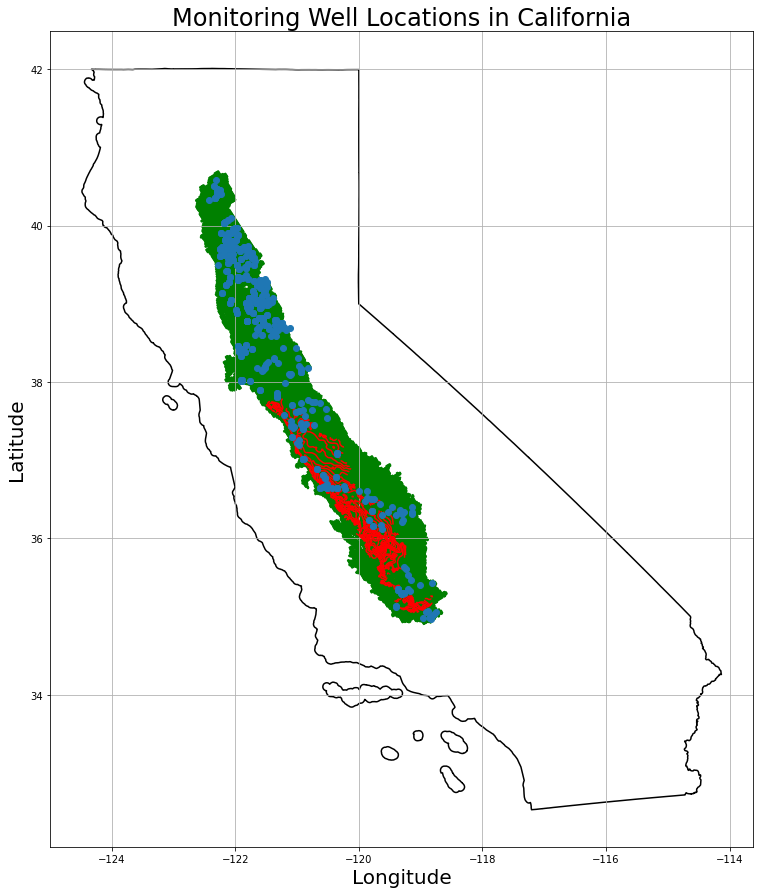

In [99]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_monitoring_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Monitoring Well Locations in California', fontsize=24)
ax.grid(zorder=0)

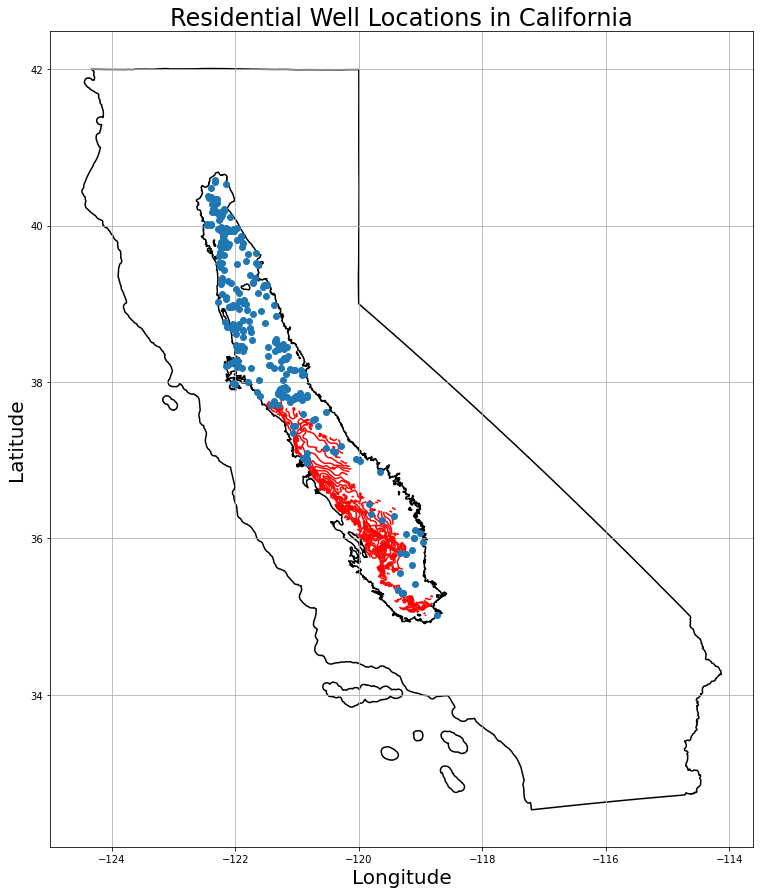

In [98]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_residential_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Residential Well Locations in California', fontsize=24)
ax.grid(zorder=0)

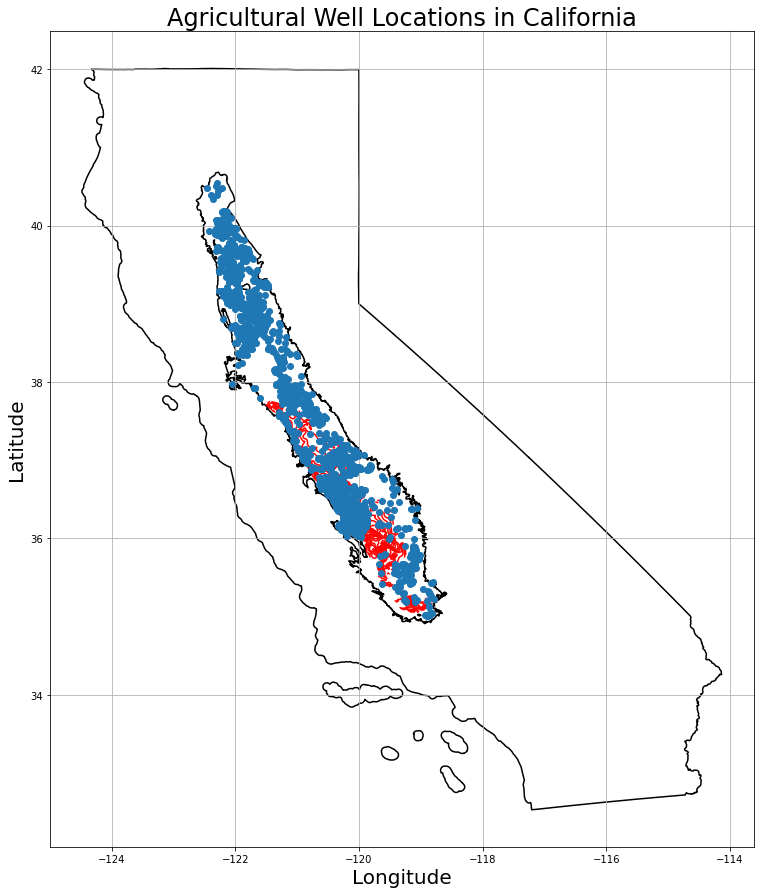

In [44]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_agricultural_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Agricultural Well Locations in California', fontsize=24)
ax.grid(zorder=0)

## Shallow vs. confined wells

This is a rehash of Claire's work and goes off of older data.

In [48]:
well_sites = pd.read_csv('./well_data/allyears_shallowconfined.csv')
well_sites.info()
print(len(np.unique(well_sites['SITE_CODE'].to_numpy())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61074 entries, 0 to 61073
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SITE_CODE                         61074 non-null  object 
 1   WLM_ID                            61074 non-null  int64  
 2   MSMT_DATE                         61074 non-null  object 
 3   WLM_RPE                           61074 non-null  float64
 4   WLM_GSE                           61074 non-null  float64
 5   GWE                               53105 non-null  float64
 6   GSE_GWE                           53105 non-null  float64
 7   WLM_QA_DESC                       12305 non-null  object 
 8   WLM_DESC                          53100 non-null  object 
 9   WLM_ACC_DESC                      53102 non-null  object 
 10  WLM_ORG_NAME                      61074 non-null  object 
 11  COOP_ORG_NAME                     61074 non-null  object 
 12  MONI

In [49]:
shallow_sites = well_sites[well_sites['type']=='shallow']

In [50]:
confined_sites = well_sites[well_sites['type']=='confined']

In [51]:
shallow_points = [Point(xy) for xy in zip(shallow_sites["long"], well_sites["lat"])]
crs='epsg:4326'
shallow_sites = gpd.GeoDataFrame(shallow_sites, crs=crs, geometry=shallow_points)

In [52]:
confined_points = [Point(xy) for xy in zip(confined_sites["long"], confined_sites["lat"])]
confined_sites = gpd.GeoDataFrame(confined_sites, crs=crs, geometry=confined_points)

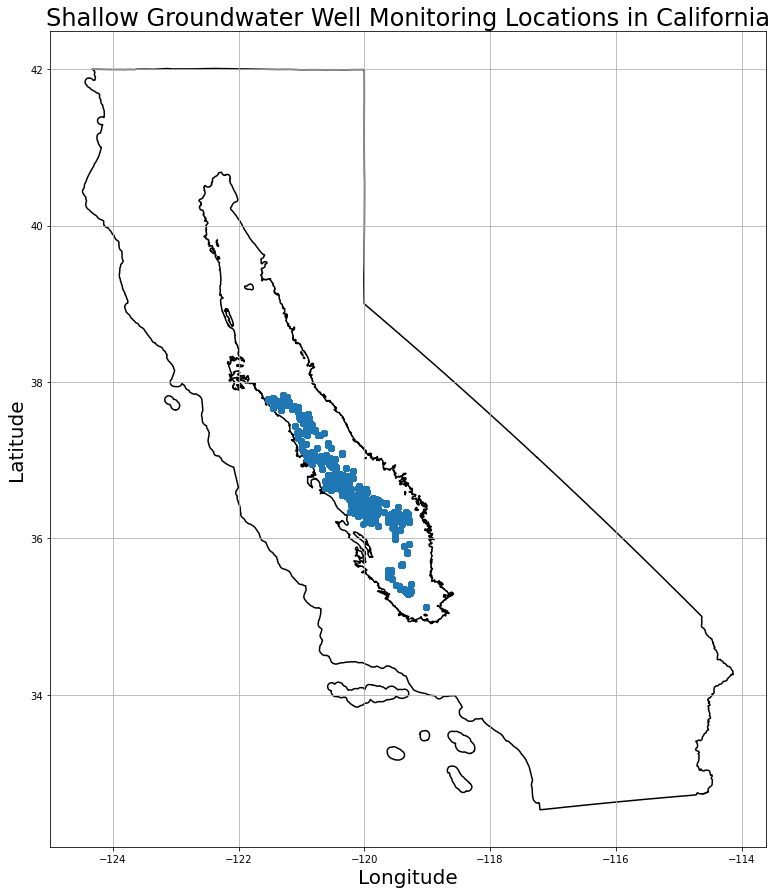

In [53]:
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
shallow_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Shallow Groundwater Well Monitoring Locations in California', fontsize=24)
ax.grid(zorder=0)

SITE_CODE	text	Site Code	
Location based 18 character alphanumeric code assigned to each well

WLM_ID	numeric	Water Level Measurement Unique Id	
Unique database identifier for water level measurement

MSMT_DATE	timestamp	Water Level Measurement Date (PST)	
Date/Time (in PST) the groundwater level measurement was collected.

WLM_RPE	numeric	RPE for a specific water level measurement record	
Reference Point Elevation used to collect the groundwater level measurement in feet referenced to the North American Vertical Datum of 1988 (NAVD88)

WLM_GSE	numeric	GSE for a specific water level measurement record	
Ground Surface Elevation at the well site in feet referenced to the North American Vertical Datum of 1988 (NAVD88)

GWE	numeric	Groundwater Elevation	
Groundwater elevation in feet above mean sea level, using NAVD88.

GSE_GWE	numeric	Ground Surface Elevation to Groundwater Elevation	
Depth to groundwater elevation in feet below ground surface.

WLM_QA_DESC	text	Water Level Measurement Quality Description	
Quality assurance description for groundwater level measurement (questionable or no measurement code)

WLM_DESC	text	Water Level Measurement Method Description	
Description of water level measurement method.

WLM_ACC_DESC	text	Water Level Measurement Accuracy Description	
Description for accuracy of water level (elevation) measurement.

WLM_ORG_NAME	text	Submitting Organization	
Organization which submitted the water level measurement.

COOP_ORG_NAME	text	Collecting Organization	
Organization that collected the water level measurement. (May be the Submitting Organization or a third-party cooperating organization.)

MONITORING_PROGRAM	text	DWR Monitoring Program	
DWR Monitoring Program this well is primarily monitored under, e.g. SGMA (Sustainable Groundwater Management Act), CASGEM (California Statewide Groundwater Elevation Monitoring program), or Voluntary.

MSMT_CMT	text	Water Level Measurement Comments	
Comments regarding this measurement.

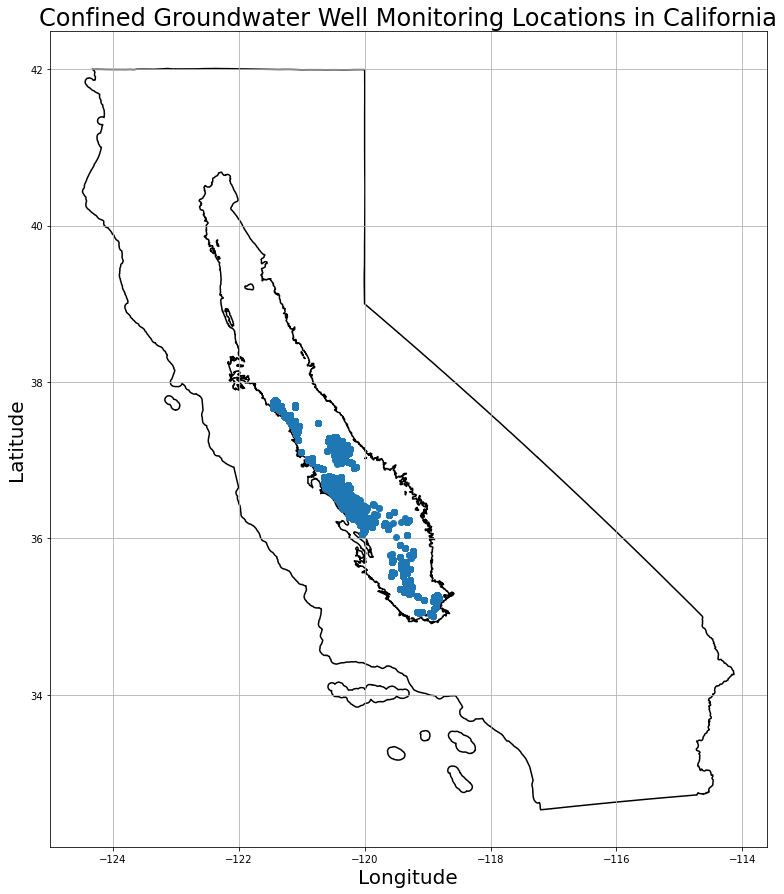

In [54]:
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
confined_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Confined Groundwater Well Monitoring Locations in California', fontsize=24)
ax.grid(zorder=0)

In [55]:
print(len(np.unique(well_sites[well_sites['type']=='shallow']['SITE_CODE'])))
print(len(np.unique(well_sites[well_sites['type']=='confined']['SITE_CODE'])))

551
742


There's actually more confined wells than shallow wells!

# continuous data

In [56]:
c_well_measurements = pd.read_csv('./well_data/continuousgroundwaterdaily.csv')
c_well_stations = pd.read_csv('./well_data/gwl-stations.csv')
c_well_codes = pd.read_csv('./well_data/groundwater_quality_codes.csv')

In [57]:
c_well_measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269333 entries, 0 to 2269332
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   STATION     object 
 1   MSMT_DATE   object 
 2   WLM_RPE     float64
 3   WLM_RPE_QC  int64  
 4   WLM_GSE     float64
 5   WLM_GSE_QC  int64  
 6   RPE_WSE     float64
 7   RPE_WSE_QC  int64  
 8   GSE_WSE     float64
 9   GSE_WSE_QC  int64  
 10  WSE         float64
 11  WSE_QC      int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 207.8+ MB


In [58]:
c_well_codes

,QUALITY_CODE,DESCRIPTION
0,1,Good data
1,2,Good quality edited data
2,10,Good Measurement
3,15,Provisional measurement
4,20,"Dry, no flow"
5,26,Data imported from historic records.
6,30,Irregular Time Rate Data - weekly/monthly read.
7,35,Estimated data imported from historic records.
8,40,Fair Measurement
9,50,Unknown Measurement Quality


In [59]:
c_well_stations["WELL_USE"].unique()

array(['Observation', nan, 'Irrigation', 'Other', 'Residential',
       'Stockwatering', 'Industrial'], dtype=object)

In [65]:
c_monitoring_wells = c_well_stations[(c_well_stations["WELL_USE"] == 'Observation') & 
                              (~c_well_stations["WCR_NO"].isna()) & 
                              (c_well_stations["WCR_NO"] != 'YES')]
c_residential_wells = c_well_stations[(c_well_stations["WELL_USE"] == 'Residential') & 
                              (~c_well_stations["WCR_NO"].isna()) & 
                              (c_well_stations["WCR_NO"] != 'YES')]
c_agricultural_wells = c_well_stations[(c_well_stations["WELL_USE"] == 'Irrigation') & 
                              (~c_well_stations["WCR_NO"].isna()) & 
                              (c_well_stations["WCR_NO"] != 'YES')]

In [66]:
c_monitoring_site_points = [Point(xy) for xy in zip(c_monitoring_wells["LONGITUDE"], c_monitoring_wells["LATITUDE"])]
c_residential_site_points = [Point(xy) for xy in zip(c_residential_wells["LONGITUDE"], c_residential_wells["LATITUDE"])]
c_agricultural_site_points = [Point(xy) for xy in zip(c_agricultural_wells["LONGITUDE"], c_agricultural_wells["LATITUDE"])]

In [67]:
c_monitoring_sites = gpd.GeoDataFrame(c_monitoring_wells, crs=crs, geometry=c_monitoring_site_points)
c_residential_sites = gpd.GeoDataFrame(c_residential_wells, crs=crs, geometry=c_residential_site_points)
c_agricultural_sites = gpd.GeoDataFrame(c_agricultural_wells, crs=crs, geometry=c_agricultural_site_points)

In [68]:
cv_c_monitoring_sites = c_monitoring_sites.sjoin(CV_map)
cv_c_residential_sites = c_residential_sites.sjoin(CV_map)
cv_c_agricultural_sites = c_agricultural_sites.sjoin(CV_map)

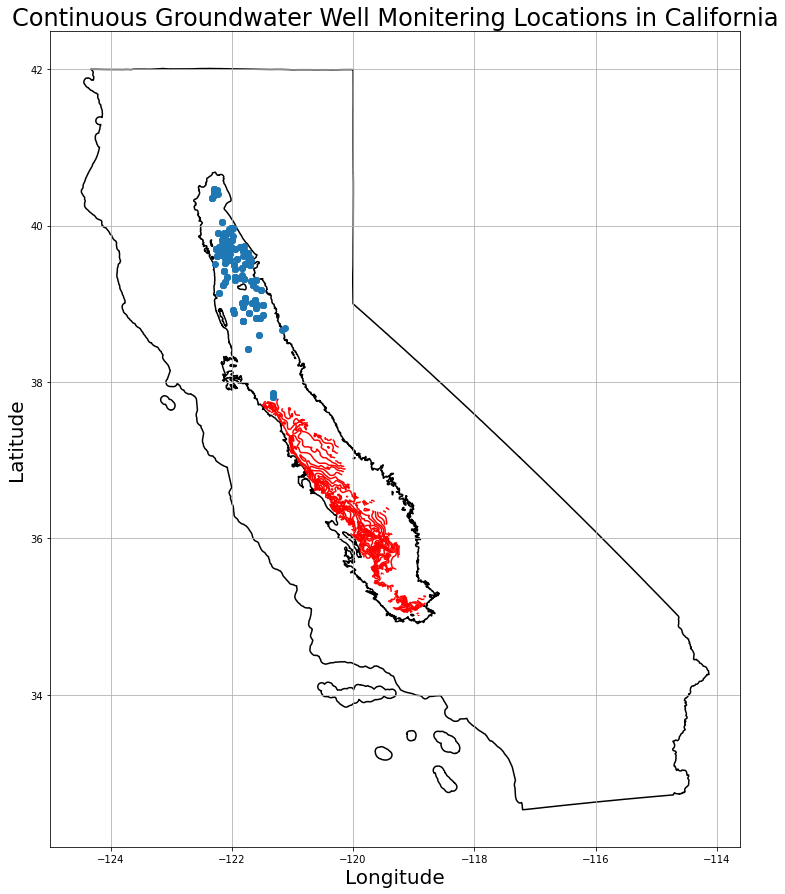

In [69]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_c_monitoring_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Continuous Groundwater Well Monitering Locations in California', fontsize=24)
ax.grid(zorder=0)

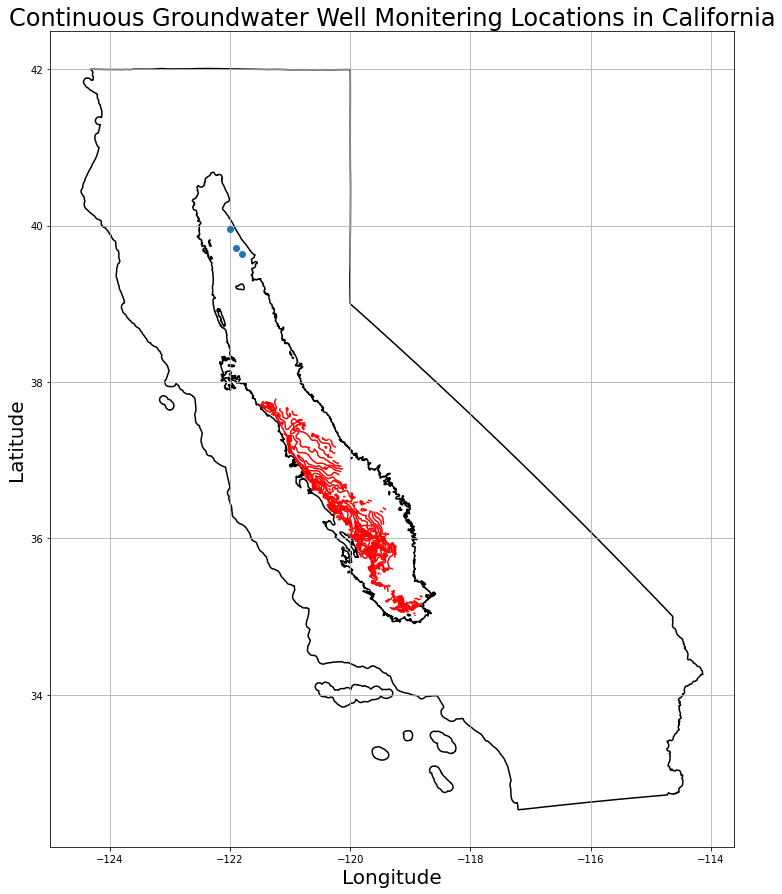

In [70]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_c_residential_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Continuous Groundwater Well Monitering Locations in California', fontsize=24)
ax.grid(zorder=0)

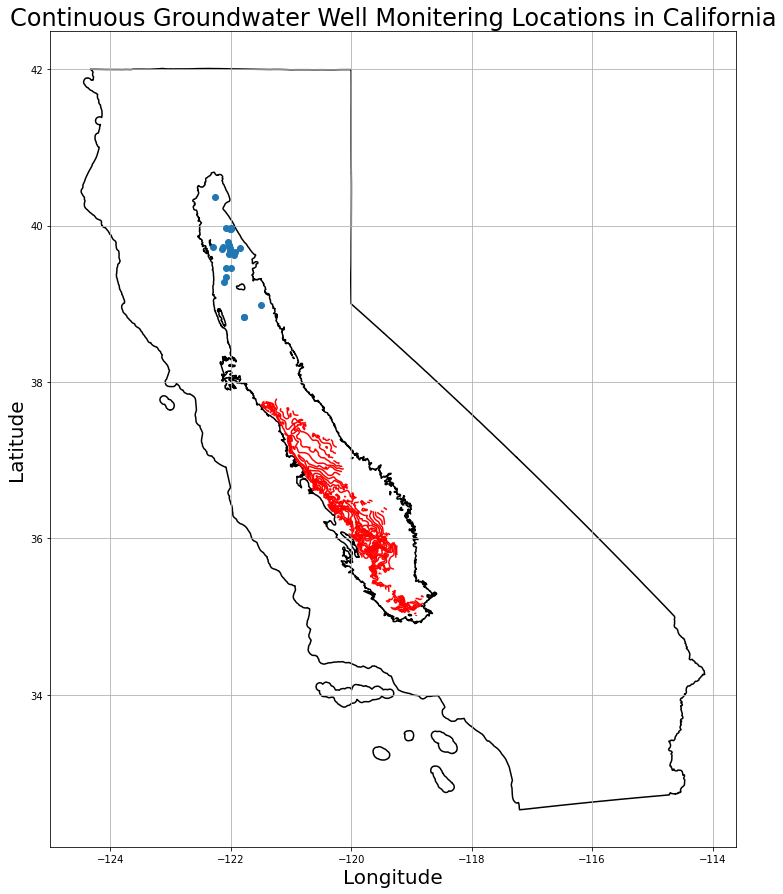

In [71]:
#plt.figure(figsize=(8,6))
#plt.plot(well_sites["LONGITUDE"], well_sites["LATITUDE"], '.')
#plt.grid()
fig, ax = plt.subplots(figsize=(15,15))
CA_map.boundary.plot(ax=ax, color='k', zorder=1)
CV_map.boundary.plot(ax=ax, color='k', zorder=1)
CC_map.plot(ax=ax, color='r')
cv_c_agricultural_sites.plot(ax=ax, zorder=2)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Continuous Groundwater Well Monitering Locations in California', fontsize=24)
ax.grid(zorder=0)

In [ ]:
c_monitoring_sites.sort_values("WELL_NAME").head()

In [72]:
len(c_monitoring_site_points)

321

In [ ]:
monitoring_sites.sort_values("WELL_NAME").head()

Talk with Christina (03/17/2022)

- most concerned with the semiconfined aquifer in the north
- wants piezometers to measure pressure to see if well is truly measuring water table
- some wells have multiple screenings/perforations to capture drainage areas rather than intermitent clays (check well logs)
- if there's not enough observation wells, use agricultural or residential wells
- thinks the key is in the well logs (first depth to water measurement vs. water table measurement at the end of drilling. If it's different -> not truly measuring water table)
- DWR has started analyzing them but it's all over the place.